## Importing the libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Importing the data

In [2]:
train_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
X_test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
X_test_copy = X_test.copy()

X_train = train_data.drop("SalePrice", axis  = 1)
y_train = train_data["SalePrice"]

In [3]:
X_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


### Exploratory Data Analysis

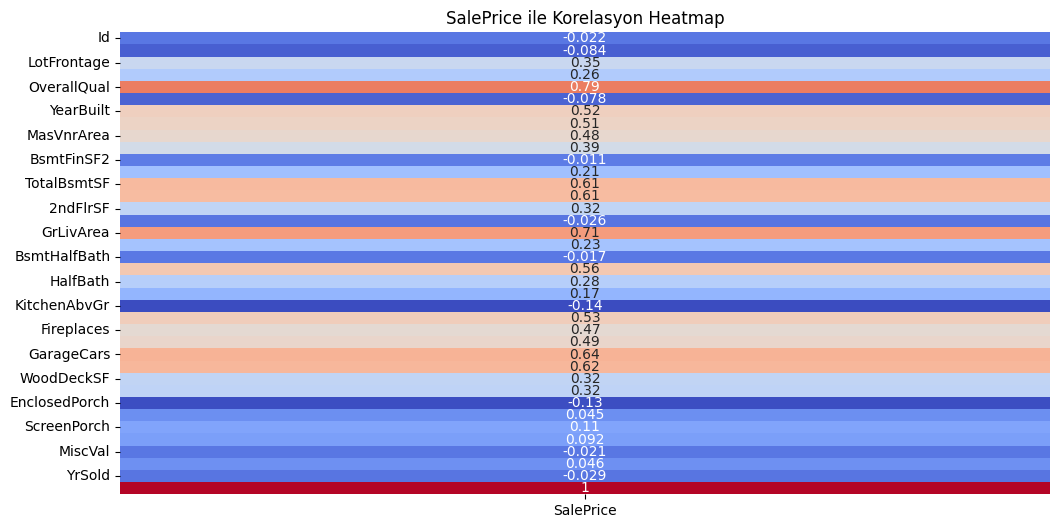

In [4]:
corr_matrix = train_data.corr(numeric_only = True)

# SalePrice ile olan korelasyonları alın
saleprice_corr = corr_matrix["SalePrice"]

# Korelasyonları görselleştirin
plt.figure(figsize=(12, 6))
sns.heatmap(saleprice_corr.to_frame(), annot=True, cmap='coolwarm', cbar=False)
plt.title('SalePrice ile Korelasyon Heatmap')
plt.show()

#### Print Top 5 and Last 5 Features correlation with SalePrice

In [5]:
saleprice_corr.sort_values(ascending = False)[1:5]

OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64

In [6]:
saleprice_corr.sort_values(ascending = True)[0:5]

KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
Name: SalePrice, dtype: float64

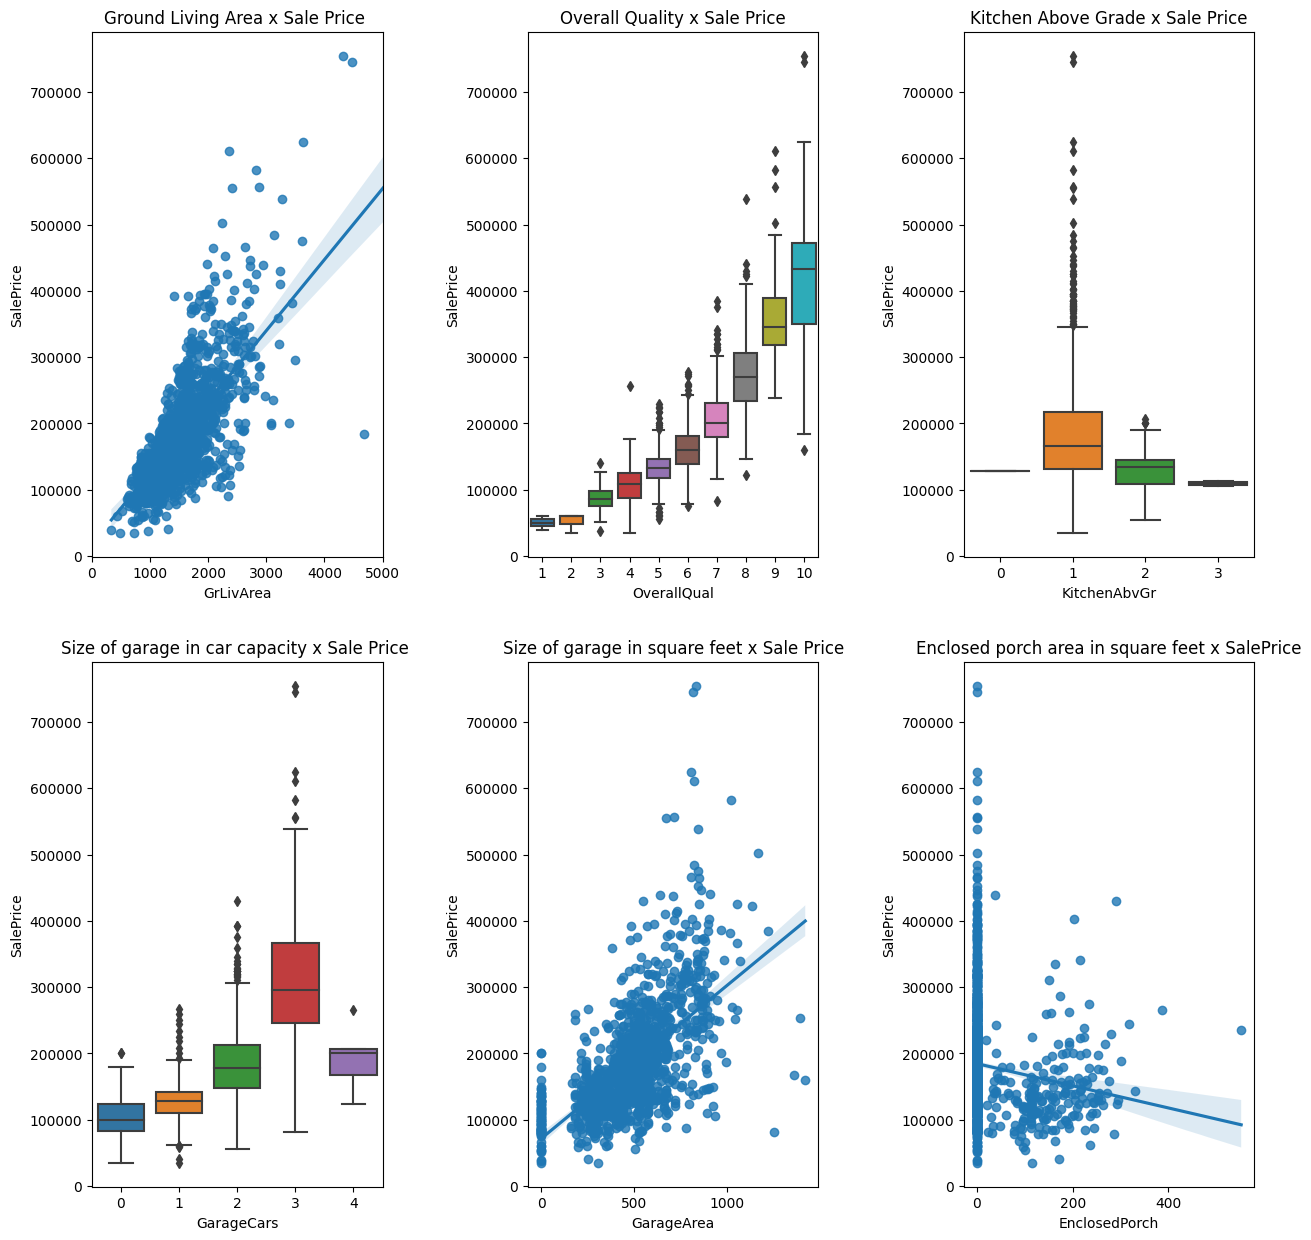

In [7]:
fig, ax = plt.subplots(2,3, figsize = (15,15))

ax1 = sns.regplot(x = "GrLivArea", y = "SalePrice", data = train_data, ax = ax[0][0]);
ax2 = sns.boxplot(x = "OverallQual", y = "SalePrice", data = train_data, ax = ax[0][1]);
ax3 = sns.boxplot(x = "GarageCars", y = "SalePrice", data = train_data, ax = ax[1][0]);
ax4 = sns.regplot(x = "GarageArea", y = "SalePrice", data = train_data, ax = ax[1][1])
ax5 = sns.boxplot(x = "KitchenAbvGr", y = "SalePrice", data = train_data, ax = ax[0][2]);
ax6 = sns.regplot(x = "EnclosedPorch", y = "SalePrice", data = train_data, ax = ax[1][2]);




ax1.set_xlim(0,5000);
ax1.set_title("Ground Living Area x Sale Price ")
ax2.set_title("Overall Quality x Sale Price")
ax3.set_title("Size of garage in car capacity x Sale Price ")
ax4.set_title("Size of garage in square feet x Sale Price")
ax5.set_title("Kitchen Above Grade x Sale Price")
ax6.set_title("Enclosed porch area in square feet x SalePrice")
plt.subplots_adjust(wspace=0.5)



When examining the graphs:

1.Graph: Looking at the graph, there is a strong positive correlation between GrLivArea and Sale Price.

2.Graph: As expected, as Overall Quality increases, the sale prices of homes also increase.

3.Graph: In the graph, there is a low negative correlation between Kitchen Above Grade and Sale Price.

4.Graph: In the graph, while the capacity of garages and the sale prices of homes have a lower correlation, there is still a positive correlation.

5.Graph: In the graph, there is a strong positive correlation between the size of the garage area and Sale Price.

6.Graph: In the graph, there is a low negative correlation between Enclosed Porch Area and Sale Price. We can observe this by looking at the slope and direction of the line.





Drop the "PoolQC", "Fence" and "MiscFeature" columns, because the bigger portion of the data is empty.

In [8]:
drop_cols = ["PoolQC","Fence","MiscFeature"]
X_train.drop(drop_cols, axis = 1, inplace = True)
X_test.drop(drop_cols, axis = 1, inplace = True)

### Preparing Data

Before jumping into encoding, we'll investigate the dataset. Specifically, we'll look at the 'Condition2' column. The code cell below prints the unique entries in both the training and validation sets.

In [9]:
print("Unique values in 'Condition2' column in training data:", X_train['Condition2'].unique())
print("\nUnique values in 'Condition2' column in validation data:", X_test['Condition2'].unique())

Unique values in 'Condition2' column in training data: ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']

Unique values in 'Condition2' column in validation data: ['Norm' 'Feedr' 'PosA' 'PosN' 'Artery']


Fitting an encoder to a column in the training data creates a corresponding integer-valued label for each unique value that appears in the training data. In the case that the validation data contains values that don't also appear in the training data, the encoder will throw an error, because these values won't have an integer assigned to them. Notice that the 'Condition2' column in the validation data contains the values 'RRAn' and 'RRNn', but these don't appear in the training data -- thus, if we try to use an ordinal encoder with scikit-learn, the code will throw an error.

This is a common problem that you'll encounter with real-world data, and there are many approaches to fixing this issue. For instance, you can write a custom ordinal encoder to deal with new categories. The simplest approach, however, is to drop the problematic categorical columns.

Run the code cell below to save the problematic columns to a Python list bad_label_cols. Likewise, columns that can be safely ordinal encoded are stored in good_label_cols.

In [10]:
# Categorical columns in the training data

object_cols = []

for col in X_train.columns:
    if X_train[col].dtype == "object":
        object_cols.append(col)

# Columns that can be safely ordinal encoded

good_label_cols = []

for i in object_cols:
    if set(X_test[i]).issubset(set(X_train[i])):
        good_label_cols.append(i)
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
print('Categorical columns that will be ordinal encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

Categorical columns that will be ordinal encoded: ['Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['SaleType', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'MSZoning', 'Utilities', 'Functional']


In [11]:
label_X_train = X_train.drop(bad_label_cols, axis=1)
label_X_test = X_test.drop(bad_label_cols, axis=1)

### Impute the Missing Values

In [12]:
num_cols = label_X_train.select_dtypes(exclude = "object")

cat_cols = label_X_train.select_dtypes(include = "object")

num_cols = num_cols.columns
cat_cols = cat_cols.columns


In [13]:
kategorik_imputer = SimpleImputer(strategy='most_frequent')

label_X_train[cat_cols] = kategorik_imputer.fit_transform(label_X_train[cat_cols])
label_X_test[cat_cols] = kategorik_imputer.fit_transform(label_X_test[cat_cols])

num_imputer = SimpleImputer(strategy = "median")

label_X_train[num_cols] = num_imputer.fit_transform(label_X_train[num_cols])
label_X_test[num_cols] = num_imputer.fit_transform(label_X_test[num_cols])

### Ordinal Encoding

In [14]:
from sklearn.preprocessing import OrdinalEncoder

# Apply ordinal encoder 
ordinal_encoder = OrdinalEncoder()

label_X_train[good_label_cols] = ordinal_encoder.fit_transform(X_train[good_label_cols])
label_X_test[good_label_cols] = ordinal_encoder.transform(X_test[good_label_cols])



### CatBoostRegressor 

In [15]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(depth = 6, iterations = 1000, learning_rate = 0.05)
model.fit(label_X_train, y_train)
prediction = model.predict(label_X_test)

0:	learn: 76780.7824867	total: 57.9ms	remaining: 57.8s
1:	learn: 74391.2653783	total: 61.7ms	remaining: 30.8s
2:	learn: 72118.6157119	total: 64.9ms	remaining: 21.6s
3:	learn: 69919.0024673	total: 68.1ms	remaining: 16.9s
4:	learn: 67784.4419076	total: 71.2ms	remaining: 14.2s
5:	learn: 65900.3710972	total: 74.3ms	remaining: 12.3s
6:	learn: 63913.3392569	total: 77.3ms	remaining: 11s
7:	learn: 62076.5302386	total: 80.4ms	remaining: 9.97s
8:	learn: 60201.0519499	total: 83.6ms	remaining: 9.2s
9:	learn: 58622.2805267	total: 86.6ms	remaining: 8.57s
10:	learn: 57206.7595485	total: 89.6ms	remaining: 8.05s
11:	learn: 55836.1082063	total: 92.6ms	remaining: 7.62s
12:	learn: 54371.3821166	total: 95.5ms	remaining: 7.25s
13:	learn: 52950.6599809	total: 98.5ms	remaining: 6.94s
14:	learn: 51757.5374152	total: 101ms	remaining: 6.66s
15:	learn: 50482.9306760	total: 104ms	remaining: 6.42s
16:	learn: 49271.6423621	total: 107ms	remaining: 6.2s
17:	learn: 48048.9907521	total: 110ms	remaining: 6.01s
18:	learn:

### Save The Model

In [16]:
X_test["SalePrice"]= prediction

final = X_test[["Id","SalePrice"]]
final["Id"]= final["Id"].astype("int32")
final = final.set_index("Id")

final.to_csv("submission.csv")